# Model Experimentation

Experiment and finalize the model. It covers EDA, outlier treatment, transformation, training, model evaluation, and comparison across models.

## Imports, Configuration, and Initialization

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import os.path as op
import shutil
import warnings

import numpy as np
import pandas as pd
from category_encoders import TargetEncoder
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder,
                                   StandardScaler)
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.estimator_checks import check_estimator

import ta_lib.eda.api as eda
import ta_lib.reports.api as reports

from ta_lib.core.api import (DEFAULT_ARTIFACTS_PATH, create_context,
                             display_as_tabs, get_dataframe,
                             get_feature_names_from_column_transformer,
                             get_package_path, initialize_environment,
                             list_datasets, load_dataset, load_pipeline,
                             save_dataset, save_pipeline, string_cleaning)
from ta_lib.data_processing.api import Outlier
from ta_lib.regression.api import (RegressionComparison, RegressionReport,
                                   SKLStatsmodelOLS)

from xgboost import XGBRegressor


warnings.filterwarnings(
    'ignore',
    message="pandas.Int64Index is deprecated and will be removed from pandas \
in a future version. Use pandas.Index with the appropriate dtype instead.",
    category=FutureWarning
)

warnings.filterwarnings(
    'ignore',
    message="pandas.Float64Index is deprecated and will be removed from \
pandas in a future version. Use pandas.Index with the appropriate \
dtype instead.",
    category=FutureWarning
)

In [12]:
initialize_environment(debug=False, hide_warnings=True)

## 0. Initialization

In [13]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

artifacts_folder

'/home/naveen/module5/case-study/src/../artifacts'

In [14]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

list_datasets(context)

['/raw/google_search',
 '/raw/product_manufacturer',
 '/raw/sales',
 '/raw/social_media',
 '/raw/theme',
 '/raw/theme_product',
 '/cleaned/google_search',
 '/cleaned/product_manufacturer',
 '/cleaned/sales',
 '/cleaned/social_media',
 '/cleaned/theme',
 '/cleaned/theme_product',
 '/cleaned/final_cleaned_merged_data',
 '/processed/sales',
 '/train/sales/features',
 '/train/sales/target',
 '/test/sales/features',
 '/test/sales/target',
 '/score/sales/output']

## 1. Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices, and so on.

### 1.1 Read Train and Test Data

In [15]:
X_train = load_dataset(context, 'train/sales/features')
y_train = load_dataset(context, 'train/sales/target')
print("TRAIN:", X_train.shape, y_train.shape)

X_test = load_dataset(context, 'test/sales/features')
y_test = load_dataset(context, 'test/sales/target')
print("TEST:", X_test.shape, y_test.shape)

['/home/naveen/module5/case-study/src/../data/train/sales/features.parquet']
['/home/naveen/module5/case-study/src/../data/train/sales/target.parquet']
TRAIN: (2095, 10) (2095, 1)
['/home/naveen/module5/case-study/src/../data/test/sales/features.parquet']
['/home/naveen/module5/case-study/src/../data/test/sales/target.parquet']
TEST: (524, 10) (524, 1)


In [16]:
X_train.columns

Index(['theme_id', 'total_post', 'search_volume', 'sales_date',
       'sales_units_value', 'sales_lbs_value', 'theme_name', 'competitor_list',
       'competitor_share', 'competitors_count'],
      dtype='object')

In [17]:
X_train_mod = X_train.copy().drop(
    columns=[
        "sales_date",
        "theme_id",
        "competitor_list",
        "sales_lbs_value",
        "sales_units_value",
    ],
    axis=1
)
X_test_mod = X_test.copy().drop(
    columns=[
        "sales_date",
        "theme_id",
        "competitor_list",
        "sales_lbs_value",
        "sales_units_value",
    ],
    axis=1
)

X_train_mod.columns, X_test_mod.columns

(Index(['total_post', 'search_volume', 'theme_name', 'competitor_share',
        'competitors_count'],
       dtype='object'),
 Index(['total_post', 'search_volume', 'theme_name', 'competitor_share',
        'competitors_count'],
       dtype='object'))

In [18]:
X_train_mod.describe()

,total_post,search_volume,competitor_share,competitors_count
count,2095.000000,2095.000000,2095.000000,2095.000000
mean,713.903580,25657.512172,0.170991,1.622912
std,1143.347441,33909.530563,0.193288,1.306091
min,0.000000,2.000000,0.000000,0.000000
25%,87.000000,4036.000000,0.063550,1.000000
50%,311.000000,11661.000000,0.112253,1.000000
75%,781.500000,38391.500000,0.206332,2.000000
max,14129.000000,526199.000000,0.941436,4.000000


### 1.2 Feature Engineering Pipelines

General Steps in the Feature Transformation are as follows:
- Outlier Treatment
- Encoding of Categorical Columns
- Missing Values Imputation
- Any other engineering steps come here

For Feature Engineering and Model Building `sklearn.pipeline.Pipeline` is leveraged.

In [19]:
# Collecting different types of columns for transformations
cat_columns = X_train_mod.select_dtypes('object').columns
num_columns = X_train_mod.select_dtypes('number').columns

cat_columns, num_columns

(Index(['theme_name'], dtype='object'),
 Index(['total_post', 'search_volume', 'competitor_share', 'competitors_count'], dtype='object'))

#### 1.2.1 Outlier Handling
- A `CustomTransformer` is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either **drop** or **cap** the outliers can be passed during the transform call
- If we want to treat outliers for some columns, then we can pass the columns as argument to the Transformer

**NOTE:** This will go into production code.

In [20]:
outlier_transformer = Outlier(method='mean')

outlier_transformer

In [21]:
print("Earlier Shape:", X_train_mod.shape)
X_train_mod = outlier_transformer.fit_transform(X_train_mod)
print("Shape After Transformation:", X_train_mod.shape)

Earlier Shape: (2095, 5)
Shape After Transformation: (2095, 5)


In [22]:
X_train_mod.competitors_count.unique()

array([1., 2., 3., 4., 0.])

#### 1.2.2 Encoding

- Commonly *target encoding* is done for categorical variables with *too many levels*.
- For *fewer levels* *one hot encoding/label encoding* is preferred.
- If there is *one dominant level*, we can use *binary encoding*.

**NOTE:** This will go into production code

In [23]:
# categorical_transformer = ColumnTransformer([
#     # Categorical transformer
#     ("cat_enc", OneHotEncoder(), cat_columns),

#     # Numerical Transformer
#     ("med_enc", SimpleImputer(strategy="median"), num_columns),
# ])

# categorical_transformer

In [24]:
# sample_X = X_train.sample(frac=0.1, random_state=context.random_seed)
# sample_y = y_train.loc[sample_X.index]

# sample_X.sample(3, random_state=10)

In [25]:
# sample_X_train = get_dataframe(
#     categorical_transformer.fit_transform(sample_X, sample_y), 
#     get_feature_names_from_column_transformer(categorical_transformer)
# )

# sample_X_train.sample(3, random_state=10)

#### 1.2.3 Other Feature Transformations

- Make the custom transformer to add the three extra columns we had created earlier
- use standard scalar for the numerical attributes

In [26]:
num_pipeline= Pipeline([
    ('med_imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_pipeline

Pipeline(steps=[('med_imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

In [27]:
full_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_columns),
    ("num", num_pipeline, num_columns),
], verbose_feature_names_out=False)

full_transformer

ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                 Index(['theme_name'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('med_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 Index(['total_post', 'search_volume', 'competitor_share', 'competitors_count'], dtype='object'))],
                  verbose_feature_names_out=False)

In [28]:
sample_X = X_train_mod.sample(frac=0.1, random_state=context.random_seed)
sample_y = y_train.loc[sample_X.index]

In [29]:
def remove_the_prefix_from_columns(
    original_columns_list: list,
    prefixed_columns_list: list
) -> list:
    """
    Return the list of columm names with the transformer prefix removed
    """

    for i, col_name in enumerate(original_columns_list):
        prefixed_columns_list[i] = prefixed_columns_list[i][- len(col_name): ]

    return prefixed_columns_list

In [30]:
def cust_get_feature_names_from_column_transformer(
    column_transformer: ColumnTransformer,
    verbose_feature_names_out: bool = True,
) -> list:
    col_trans = column_transformer
    col_names = []

    for transformer_in_columns in col_trans.transformers_:
        # print("Current Column Transformer", transformer_in_columns)
        raw_col_names = list(transformer_in_columns[2])
        # print("The current cols to be processed:", raw_col_names)

        if isinstance(transformer_in_columns[1], Pipeline):
            # print("THIS IS A PIPELINE")
            cols = None
            pipeline = transformer_in_columns[1]
            for i, step in enumerate(pipeline.steps):
                transformer = step[1]
                # print("Current Transformer:", transformer)

                # To initialize the `cols` variable here
                if i == 0:
                    # print("This is 1st transformer in the pipeline!")
                    og_cols = transformer.feature_names_in_
                    if hasattr(transformer, "get_feature_names_out"):
                        cols = list(transformer.get_feature_names_out())
                        # print("names_out - cols:", cols)
                    elif hasattr(transformer, "get_feature_names"):
                        cols = list(transformer.get_feature_names())
                        # print("names - cols:", cols)
                    else:
                        cols = raw_col_names
                        # print("nothing - cols:", cols)
                    
                    cols = remove_the_prefix_from_columns(og_cols, cols)
                    # print("After removing prefixes:", cols)

                    continue

                if i == (len(pipeline.steps) - 1):
                    pass
                    # print("This is the last transformer in the pipeline!")
                og_cols = cols
                if hasattr(transformer, "get_feature_names_out"):
                    cols = list(transformer.get_feature_names_out(cols))
                    # print("names_out - cols:", cols)
                elif hasattr(transformer, "get_feature_names"):
                    cols = list(transformer.get_feature_names(cols))
                    # print("names - cols:", cols)
                
                cols = remove_the_prefix_from_columns(og_cols, cols)
                # print("After removing prefixes:", cols)
        else:
            transformer = transformer_in_columns[1]
            # print("This is NOT a Pipeline")
            # print("Current Transformer:", transformer)

            if isinstance(
                transformer, str
            ):  # the last transformer is ColumnTransformer's 'remainder'
                if transformer == "passthrough":
                    cols = col_trans.feature_names_in_[raw_col_names].tolist()
                    # print("passthrough - cols:", cols)
                elif transformer == "drop":
                    cols = []
                    # print("drop - cols:", cols)
                else:
                    raise RuntimeError(
                        f"Unexpected transformer action for unaccounted cols :"
                        f"{transformer} : {raw_col_names}"
                    )

            elif hasattr(transformer, "get_feature_names_out"):
                cols = list(transformer.get_feature_names_out())
                # print("names_out - cols:", cols)
            elif hasattr(transformer, "get_feature_names"):
                cols = list(transformer.get_feature_names())
                # print("names - cols:", cols)
            else:
                cols = raw_col_names
                # print("nothing - cols:", cols)


        if verbose_feature_names_out:
            # print("verbose_feature_names_out: True")
            # print("Earlier names:", cols)
            cols = [f"{transformer_in_columns[0]}_{col_}" for col_ in cols]
            # print("Final names:", cols)

        # print("Add the names to the list.")
        col_names.extend(cols)
        # print("Current Cols List", col_names)

    # print("THIS IS DONE!")

    return col_names

In [31]:
sample_X_train = get_dataframe(
    full_transformer.fit_transform(sample_X, sample_y).toarray(), 
    cust_get_feature_names_from_column_transformer(full_transformer, False)
)

print(sample_X_train.shape)

sample_X_train.sample(3, random_state=10).T

(210, 21)


,24,91,98
theme_name_beef_hamburger,0.000000,0.000000,0.000000
theme_name_blueberry,0.000000,0.000000,0.000000
theme_name_chicken,0.000000,0.000000,0.000000
theme_name_crab,0.000000,0.000000,0.000000
theme_name_ethical_packaging,0.000000,0.000000,0.000000
theme_name_ethnic_exotic,0.000000,0.000000,0.000000
theme_name_french_bisque,0.000000,1.000000,0.000000
theme_name_gmo_free,0.000000,0.000000,0.000000
theme_name_high_source_of_protein,0.000000,0.000000,0.000000
theme_name_low_carb,0.000000,0.000000,0.000000


## 2 Feature Analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will **NOT** be part of the production code, unless input data drifts, etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, and data analysis.

Running the features transformer on the complete data

In [32]:
X_train = get_dataframe(
    full_transformer.fit_transform(X_train_mod, y_train).toarray(), 
    cust_get_feature_names_from_column_transformer(full_transformer, False)
)

X_train.sample(5, random_state=context.random_seed).T

,2025,1678,583,1372,48
theme_name_beef_hamburger,0.000000,0.000000,1.000000,1.000000,0.000000
theme_name_blueberry,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_chicken,0.000000,1.000000,0.000000,0.000000,0.000000
theme_name_crab,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_ethical_packaging,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_ethnic_exotic,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_french_bisque,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_gingerbread,0.000000,0.000000,0.000000,0.000000,0.000000
theme_name_gmo_free,1.000000,0.000000,0.000000,0.000000,0.000000
theme_name_high_source_of_protein,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
X_train.isnull().sum().sum()

0

Clearly, all the missing values have been imputed.

### 2.1 Univariate Analysis

Look at each variable independently. This is useful if models have assumptions on the distribution and/or bounds on the features/target.

In [34]:
X_train.columns

Index(['theme_name_beef_hamburger', 'theme_name_blueberry',
       'theme_name_chicken', 'theme_name_crab', 'theme_name_ethical_packaging',
       'theme_name_ethnic_exotic', 'theme_name_french_bisque',
       'theme_name_gingerbread', 'theme_name_gmo_free',
       'theme_name_high_source_of_protein', 'theme_name_low_carb',
       'theme_name_low_sodium', 'theme_name_low_sugar',
       'theme_name_no_additives_preservatives', 'theme_name_poultry',
       'theme_name_salmon', 'theme_name_soy_foods', 'theme_name_tuna',
       'theme_name_vegetarian', 'total_post', 'search_volume',
       'competitor_share', 'competitors_count'],
      dtype='object')

In [35]:
kde_plots = eda.get_density_plots(y_train)

kde_plots

:Layout
   .Overlay.I :Overlay
      .Histogram.I    :Histogram   [x]   (Frequency)
      .Distribution.I :Distribution   [sales_dollars_value]   (Density)
   .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [36]:
# Save the plots in html
reports.create_report(
    {'univariate': kde_plots},
    name='feature-analysis-univariate'
)

Alternatively, the above plots can be generated as a single html as below.

In [37]:
reports.feature_analysis(X_train,'./feature-analysis-report.html')

### 2.2 Bivariate Analysis - Mutual Interactions

Find columns with high correlations and drop them.

In [38]:
binary_num_columns = [col for col in X_train.columns \
                        if X_train[col].nunique() <= 2]

binary_num_columns

['theme_name_beef_hamburger',
 'theme_name_blueberry',
 'theme_name_chicken',
 'theme_name_crab',
 'theme_name_ethical_packaging',
 'theme_name_ethnic_exotic',
 'theme_name_french_bisque',
 'theme_name_gingerbread',
 'theme_name_gmo_free',
 'theme_name_high_source_of_protein',
 'theme_name_low_carb',
 'theme_name_low_sodium',
 'theme_name_low_sugar',
 'theme_name_no_additives_preservatives',
 'theme_name_poultry',
 'theme_name_salmon',
 'theme_name_soy_foods',
 'theme_name_tuna',
 'theme_name_vegetarian']

In [39]:
corr_table = eda.get_correlation_table(X_train.drop(columns=binary_num_columns))
corr_table[corr_table["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef


- We have nothing to remove based on the inter-feature correlation.

In [40]:
curated_columns = list(
    set(X_train.columns.to_list()) 
)

columns_to_drop = []

curated_columns, columns_to_drop

(['theme_name_low_sugar',
  'theme_name_gmo_free',
  'theme_name_high_source_of_protein',
  'competitors_count',
  'theme_name_ethnic_exotic',
  'theme_name_french_bisque',
  'search_volume',
  'theme_name_salmon',
  'theme_name_chicken',
  'theme_name_poultry',
  'theme_name_soy_foods',
  'theme_name_no_additives_preservatives',
  'competitor_share',
  'theme_name_ethical_packaging',
  'theme_name_low_sodium',
  'theme_name_gingerbread',
  'theme_name_vegetarian',
  'theme_name_blueberry',
  'theme_name_beef_hamburger',
  'theme_name_crab',
  'theme_name_tuna',
  'total_post',
  'theme_name_low_carb'],
 [])

In [41]:
X_train_prepared = X_train.drop(columns=columns_to_drop, axis=1)

corr_table = eda.get_correlation_table(X_train_prepared.drop(
    columns=binary_num_columns,
    axis=1
))

corr_table[corr_table["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef


In [42]:
bivar_plots = eda.get_bivariate_plots(X_train_prepared)

bivar_plots

Column
    [0] Markdown(str)
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 5, 20), name='x_var', options=['competitors_count', ...], value='competitors_count', width=250)
                [1] Select(margin=(5, 20, 20, 20), name='y_var', options=['competitors_count', ...], value='competitors_count', width=250)
            [1] VSpacer()
    [2] Markdown(str)
    [3] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 5, 20), name='x_var', options=['theme_name_beef_hamburge...], value='theme_name_beef_hamburger..., width=250)
                [1] Select(margin=(5, 20, 20, 20), name='y_var', options=['competitors_count', ...], value='competitors_count', width=250)
            [1] VSpacer()
    [4] Markdown(str)
    [5] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 5, 20), name='x_var', options=['competitors_count', ...], value='competitors_count', width=250)
                [1] Select(margin=(5, 20, 20, 20), name='y_var', options=['theme_name_beef_hamburge...], value='theme_name_beef_hamburger..., width=250)
            [1] VSpacer()
    [6] Markdown(str)
    [7] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 5, 20), name='x_var', options=['theme_name_beef_hamburge...], value='theme_name_beef_hamburger..., width=250)
                [1] Select(margin=(5, 20, 20, 20), name='y_var', options=['theme_name_beef_hamburge...], value='theme_name_beef_hamburger..., width=250)
            [1] VSpacer()

In [43]:
# Create reports
cols = X_train_prepared.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii + 1, len(cols)):
        col2 = cols[jj]
        plots = eda.get_bivariate_plots(
            X_train_prepared,
            x_cols=[col1],
            y_cols=[col2]
        )
        all_plots.update({f'{col2} vs {col1}': plots})

reports.create_report(all_plots, name='feature-analysis-bivariate')

In [44]:
reports.feature_interactions(X_train_prepared,'./feature-interaction-report.html')

#### 2.2.2 Key Drivers - Interaction with Target Variable

In [45]:
op_plot = eda.get_target_correlation(
    X_train_prepared.drop(columns=binary_num_columns, axis=1),
    y_train,
    y_continuous=True
)
display_as_tabs([(k, v) for k,v in op_plot.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
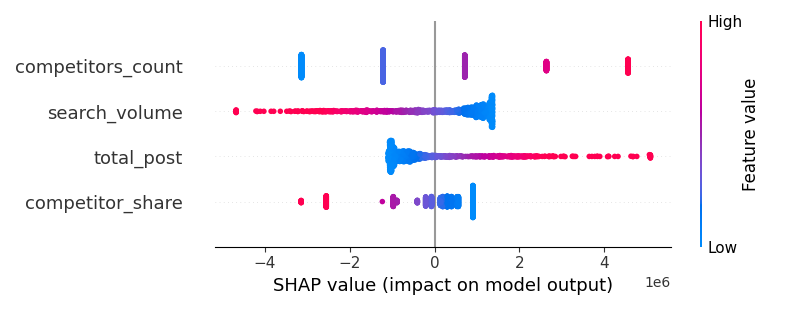

In [46]:
op_plots = eda.get_feature_importances(
    X_train_prepared.drop(columns=binary_num_columns, axis=1),
    y_train,
    y_continuous=True
)

display_as_tabs([(k, v) for k,v in op_plots.items()])

In [47]:
reports.key_drivers(
    X_train_prepared.drop(columns=binary_num_columns, axis=1),
    y_train,
    './key-drivers-report.html',
    y_continuous=True
)

All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below:

In [48]:
reports.data_exploration(
    X_train_prepared.drop(columns=binary_num_columns, axis=1),
    y_train,
    './data-exploration-report.html',
    y_continuous=True
)

In [49]:
# Saving the list of relevant columns

save_pipeline(
    curated_columns,
    op.abspath(op.join(artifacts_folder, 'curated-columns.joblib'))
)

save_pipeline(
    columns_to_drop,
    op.abspath(op.join(artifacts_folder, 'columns-to-drop.joblib'))
)

# Save the feature transformer pipeline
save_pipeline(
    full_transformer,
    op.abspath(op.join(artifacts_folder, 'full-transformer.joblib'))
)

## 3. Modelling

### 3.1 Using Linear Regression

#### 3.1.1 Feature Selection (Specific to Regression)

- Select features specific to regression
- **VIF:** Measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case-to-case basis, `VIF` thresholds change. Generally, `5` or `10` are acceptable levels.
- Usually, on a recursive basis, when removing the most collinear variable, there can be shuffle in `VIF`. 

**NOTE:** Often, this section will NOT be part of the production code.

In [50]:
X_train_prepared.columns

Index(['theme_name_beef_hamburger', 'theme_name_blueberry',
       'theme_name_chicken', 'theme_name_crab', 'theme_name_ethical_packaging',
       'theme_name_ethnic_exotic', 'theme_name_french_bisque',
       'theme_name_gingerbread', 'theme_name_gmo_free',
       'theme_name_high_source_of_protein', 'theme_name_low_carb',
       'theme_name_low_sodium', 'theme_name_low_sugar',
       'theme_name_no_additives_preservatives', 'theme_name_poultry',
       'theme_name_salmon', 'theme_name_soy_foods', 'theme_name_tuna',
       'theme_name_vegetarian', 'total_post', 'search_volume',
       'competitor_share', 'competitors_count'],
      dtype='object')

In [51]:
cols = list(X_train_prepared.drop(columns=binary_num_columns).columns)

vif = eda.calc_vif(X_train_prepared.drop(columns=binary_num_columns))

while max(vif.VIF) > 5:
    # Removw the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(X_train_prepared.drop(columns=binary_num_columns)[cols])

vif

,variables,VIF
0,total_post,1.610633
1,search_volume,1.628780
2,competitor_share,1.143793
3,competitors_count,1.513090


In [52]:
cols

['total_post', 'search_volume', 'competitor_share', 'competitors_count']

In [53]:
reg_vars = vif.query('VIF < 5').variables
reg_vars = list(reg_vars)

reg_vars

['total_post', 'search_volume', 'competitor_share', 'competitors_count']

#### 3.1.2 Data Transformations

In [54]:
# Custom Transformations like these can be utilised
def _custom_data_transform(
    df: pd.DataFrame,
    cols_to_keep: list = None
) -> pd.DataFrame:
    """
    Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols_to_keep - columns to keep in the dataframe
    """

    cols_to_keep = cols_to_keep or []
    if len(cols_to_keep):
        return df.select_columns(cols_to_keep)
    else:
        return df

#### 3.1.3 Model Training Pipeline

- Here, we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form:

```python
[
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', feature_selection_pipeline),
    ('estimator', estimator),
]
```

#### 3.1.4 Model Pipeline Build

**NOTE:** This will be part of the production code (training only)!

In [55]:
regression_pipeline_ols = Pipeline([
    # Custom Data Transformer
    (
        '',
        FunctionTransformer(
            _custom_data_transform,
            kw_args={'cols_to_keep': (reg_vars + binary_num_columns)}
        )
    ),

    # Model (estimator)
    ('estimator', SKLStatsmodelOLS())
])

regression_pipeline_ols.fit(X_train_prepared, y_train.values.ravel())

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f50a8ab1750>,
                                     kw_args={'cols_to_keep': ['total_post',
                                                               'search_volume',
                                                               'competitor_share',
                                                               'competitors_count',
                                                               'theme_name_beef_hamburger',
                                                               'theme_name_blueberry',
                                                               'theme_name_chicken',
                                                               'theme_name_crab',
                                                               'theme_name_ethical_packaging',
                                                               'theme_name_ethnic_exotic',
                                                               'theme_name_french_bisque',
                                                               'theme_name_gingerbread',
                                                               'theme_name_gmo_free',
                                                               'theme_name_high_source_of_protein',
                                                               'theme_name_low_carb',
                                                               'theme_name_low_sodium',
                                                               'theme_name_low_sugar',
                                                               'theme_name_no_additives_preservatives',
                                                               'theme_name_poultry',
                                                               'theme_name_salmon',
                                                               'theme_name_soy_foods',
                                                               'theme_name_tuna',
                                                               'theme_name_vegetarian']})),
                ('estimator', SKLStatsmodelOLS())])

In [56]:
len(reg_vars + binary_num_columns)

23

In [57]:
regression_pipeline_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     7313.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:36:31   Log-Likelihood:                -30261.
No. Observations:                2095   AIC:                         6.056e+04
Df Residuals:                    2074   BIC:                         6.068e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
intercept                              2.406e+06   2.95e+04     81.470      0.000    2.35e+06    2.46e+06
total_post                             1.214e+05   1.71e+04      7.100      0.000    8.78e+04    1.55e+05
search_volume                          2.025e+05   2.31e+04      8.750      0.000    1.57e+05    2.48e+05
competitor_share                      -5.728e+05   2.18e+04    -26.326      0.000   -6.16e+05    -5.3e+05
competitors_count                      2.199e+06   3.06e+04     71.839      0.000    2.14e+06    2.26e+06
theme_name_beef_hamburger             -1.684e+04   5.97e+04     -0.282      0.778   -1.34e+05       1e+05
theme_name_blueberry                   7.419e+05   4.66e+04     15.930      0.000    6.51e+05    8.33e+05
theme_name_chicken                    -3.456e+06   5.42e+04    -63.720      0.000   -3.56e+06   -3.35e+06
theme_name_crab                       -9.862e+05   4.91e+04    -20.097      0.000   -1.08e+06    -8.9e+05
theme_name_ethical_packaging            7.79e+05    7.5e+04     10.386      0.000    6.32e+05    9.26e+05
theme_name_ethnic_exotic              -3.904e+06   8.13e+04    -48.044      0.000   -4.06e+06   -3.74e+06
theme_name_french_bisque              -2.322e+06   5.64e+04    -41.195      0.000   -2.43e+06   -2.21e+06
theme_name_gingerbread                 -3.82e+06   3.95e+05     -9.674      0.000   -4.59e+06   -3.05e+06
theme_name_gmo_free                     4.07e+05    6.5e+04      6.261      0.000     2.8e+05    5.34e+05
theme_name_high_source_of_protein      2.942e+05   6.35e+04      4.632      0.000     1.7e+05    4.19e+05
theme_name_low_carb                    7.244e+06    6.1e+04    118.750      0.000    7.12e+06    7.36e+06
theme_name_low_sodium                 -1.349e+06   4.87e+04    -27.712      0.000   -1.44e+06   -1.25e+06
theme_name_low_sugar                  -4.783e+04   6.01e+04     -0.796      0.426   -1.66e+05       7e+04
theme_name_no_additives_preservatives  4.822e+06   1.02e+05     47.316      0.000    4.62e+06    5.02e+06
theme_name_poultry                     1.842e+05   8.02e+04      2.298      0.022     2.7e+04    3.41e+05
theme_name_salmon                      4.577e+06    4.8e+04     95.420      0.000    4.48e+06    4.67e+06
theme_name_soy_foods                   4.167e+05    8.2e+04      5.080      0.000    2.56e+05    5.78e+05
theme_name_tuna                        4.604e+04   2.79e+05      0.165      0.869   -5.01e+05    5.93e+05
theme_name_vegetarian                 -1.204e+06   7.32e+04    -16.458      0.000   -1.35e+06   -1.06e+06
==============================================================================
Omnibus:                      990.942   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      

Get the attribution table to interpret the coefficients.

In [58]:
!pip install shap

In [59]:
import shap
explainer = shap.LinearExplainer(regression_pipeline_ols['estimator'], X_train_prepared)
shap_values = explainer.shap_values(X_train_prepared)

# Average contribution of each feature
average_contributions = pd.DataFrame(shap_values, columns=X_train_prepared.columns).mean().sort_values(ascending=False)

In [92]:
y_pred = regression_pipeline_ols.predict(X_train_prepared)


In [60]:
len(regression_pipeline_ols['estimator'].coef_), regression_pipeline_ols['estimator'].intercept_

(23, 2405992.1833615145)

In [87]:
coeff = regression_pipeline_ols['estimator'].coeff_table(add_vif=False).coef.values

In [102]:
cont = (coeff[1:]*X_train_prepared).T / y_pred
cont.mean()

0      -0.386931
1      -0.155970
2      -0.029904
3      -0.026730
4      -0.327820
          ...   
2090   -1.146850
2091    2.716722
2092   -0.585303
2093   -0.023562
2094   -0.008322
Length: 2095, dtype: float64

In [126]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train_prepared, y_train)

# Get the coefficients
coefficients = model.coef_

# Get the predicted values (y_predicted)
y_predicted = model.predict(X_train_prepared)

# Calculate the contribution table (feature contributions)
contribution_table = X_train_prepared * coefficients

# Divide each feature's contribution by y_predicted
# contribution_table_normalized = contribution_table.div(y_predicted, axis=0)

# Display the contribution table
# print(contribution_table_normalized)

# Calculate the average contribution for a specific feature (e.g., 'feature1')
average_contribution_feature1 = contribution_table_normalized.mean(axis =0)
print("Average contribution of feature1:", average_contribution_feature1)


Average contribution of feature1: theme_name_beef_hamburger               -7.179284e+12
theme_name_blueberry                     4.692414e+08
theme_name_chicken                       4.647417e+11
theme_name_crab                          7.299867e+10
theme_name_ethical_packaging             1.262574e+12
theme_name_ethnic_exotic                -6.137010e+10
theme_name_french_bisque                 8.325634e+11
theme_name_gingerbread                  -1.790322e+10
theme_name_gmo_free                      1.815943e+12
theme_name_high_source_of_protein        1.301857e+11
theme_name_low_carb                     -1.072254e+10
theme_name_low_sodium                   -2.313959e+10
theme_name_low_sugar                     1.453918e+12
theme_name_no_additives_preservatives   -1.256932e+09
theme_name_poultry                       8.981635e+10
theme_name_salmon                       -9.048561e+09
theme_name_soy_foods                    -2.760358e+10
theme_name_tuna                          2.90837

In [62]:
units_sold_2019 = 2273022883  # sales in units in 2019 by A

units_sold_2019

2273022883

In [63]:
# Determine the  5% overal increase in sales
desired_increase = 0.05 * units_sold_2019

desired_increase

113651144.15

From the above attribution table, we can interpret them as follows:
- `1 unit` **increase** in the `total_post` leads to `52.0 units` increase in the target variable, i.e., `sales_dollars_value`.
- `1 unit` **increase** in the `search_volume` leads to `5.0 units` increase in the `sales_dollars_value`.
- `1 unit` **increase** in the `sales_units_value` leads to `5.0 units` increase in the `sales_dollars_value`.
- `1 unit` **increase** in the `product_unit_price` leads to `31050.0 units` increase in the `sales_dollars_value`.

**NOTE:** All the above increases are increase in *weekly* sales.

Then, the changes in one year would be as follows (assuming there are 52 weeks in a year):
- `1 unit` **increase** in the `total_post` leads to `2704.0 units` increase in the `sales_dollars_value`, yearly.
- `1 unit` **increase** in the `search_volume` leads to `260.0 units` increase in the `sales_dollars_value`, yearly.
- `1 unit` **increase** in the `sales_units_value` leads to `260.0 units` increase in the `sales_dollars_value`, yearly.
- `1 unit` **increase** in the `product_unit_price` leads to `1614600.0 units` increase in the `sales_dollars_value`, yearly.

In [64]:
(desired_increase / (5 * 52))

437119.7851923077

So, that means for the `5%` sales increase (i.e., `395436737.5`) in an year, we need:
- `437119` more posts must be generated in the next year
- `1520910` more search volume must be generated in the next year

In [65]:
(5 / len(X_train_prepared)) * 100

0.23866348448687352

#### 3.1.5 Model Evaluation (Linear Model)

**NOTE:** This will be part of the production code.

In [66]:
regression_pipeline = Pipeline([
    (
        '',
        FunctionTransformer(
            _custom_data_transform,
            kw_args={'cols_to_keep': (reg_vars + binary_num_columns)}
        )
    ),
    ('Linear Regression', SKLStatsmodelOLS())
])

regression_pipeline

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f50a8ab1750>,
                                     kw_args={'cols_to_keep': ['total_post',
                                                               'search_volume',
                                                               'competitor_share',
                                                               'competitors_count',
                                                               'theme_name_beef_hamburger',
                                                               'theme_name_blueberry',
                                                               'theme_name_chicken',
                                                               'theme_name_crab',
                                                               'theme_name_ethical_packaging',
                                                               'theme_name_ethnic_exotic',
                                                               'theme_name_fre...isque',
                                                               'theme_name_gingerbread',
                                                               'theme_name_gmo_free',
                                                               'theme_name_high_source_of_protein',
                                                               'theme_name_low_carb',
                                                               'theme_name_low_sodium',
                                                               'theme_name_low_sugar',
                                                               'theme_name_no_additives_preservatives',
                                                               'theme_name_poultry',
                                                               'theme_name_salmon',
                                                               'theme_name_soy_foods',
                                                               'theme_name_tuna',
                                                               'theme_name_vegetarian']})),
                ('Linear Regression', SKLStatsmodelOLS())])

In [67]:
X_test_prepared = get_dataframe(
    full_transformer.transform(X_test_mod).toarray(), 
    cust_get_feature_names_from_column_transformer(full_transformer, False)
)

X_test_prepared

,theme_name_beef_hamburger,theme_name_blueberry,theme_name_chicken,theme_name_crab,theme_name_ethical_packaging,theme_name_ethnic_exotic,theme_name_french_bisque,theme_name_gingerbread,theme_name_gmo_free,theme_name_high_source_of_protein,...,theme_name_no_additives_preservatives,theme_name_poultry,theme_name_salmon,theme_name_soy_foods,theme_name_tuna,theme_name_vegetarian,total_post,search_volume,competitor_share,competitors_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.434486,-0.606977,2.588268,-0.477042
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.316338,0.325676,-0.407214,-0.477042
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.546009,0.538034,-0.919651,-1.242868
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.695074,-0.745379,-0.145030,-0.477042
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.648698,-0.186912,-0.919651,-1.242868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.500737,-0.569635,2.588268,-0.477042
520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.417923,-0.613189,2.588268,-0.477042
521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.724887,-0.858586,-0.919651,-1.242868
522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000563,-0.272424,0.984838,0.288784


In [68]:
X_test_prepared = X_test_prepared.drop(
    columns=(columns_to_drop),
    axis=1
)

X_test_prepared.columns

Index(['theme_name_beef_hamburger', 'theme_name_blueberry',
       'theme_name_chicken', 'theme_name_crab', 'theme_name_ethical_packaging',
       'theme_name_ethnic_exotic', 'theme_name_french_bisque',
       'theme_name_gingerbread', 'theme_name_gmo_free',
       'theme_name_high_source_of_protein', 'theme_name_low_carb',
       'theme_name_low_sodium', 'theme_name_low_sugar',
       'theme_name_no_additives_preservatives', 'theme_name_poultry',
       'theme_name_salmon', 'theme_name_soy_foods', 'theme_name_tuna',
       'theme_name_vegetarian', 'total_post', 'search_volume',
       'competitor_share', 'competitors_count'],
      dtype='object')

In [69]:
regression_linear_report = RegressionReport(
    model=regression_pipeline,
    x_train=X_train_prepared,
    y_train=y_train,
    x_test= X_test_prepared,
    y_test= y_test,
    refit=True
)

regression_linear_report

In [70]:
regression_linear_report.get_report(
    include_shap=False,
    file_path='regression-linear-model-report'
)

**Dev Notes**

Use SHAP for variable interpretability.

<details>

1. Use SHAP=True to generate variable interpretability plots in the report
2. SHAP is recommended for non parameteric models such as RF, xgboost.
3. However, SHAP reports are time consuming depending on no.of records and model complexity.

</details>

#### 3.1.6 Residual Analysis

- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- We took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [71]:
threshold=0.3

residual_analysis = X_test_prepared.copy()

residual_analysis['prediction'] = regression_pipeline_ols.predict(
    X_test_prepared
)
residual_analysis['actual'] = y_test.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[
    (
        (residual_analysis['prediction'] > (
            (1 + threshold) * residual_analysis['actual']
        )) \
            & (residual_analysis['actual'] > 100)
    ),
    'forecast_flag'
] = 'over predict'
residual_analysis.loc[
    (
        (residual_analysis['prediction'] > (
            (1 - threshold) * residual_analysis['actual']
        )) \
            & (residual_analysis['actual'] > 100)
    ),
    'forecast_flag'
] = 'under predict'

In [72]:
residual_analysis

,theme_name_beef_hamburger,theme_name_blueberry,theme_name_chicken,theme_name_crab,theme_name_ethical_packaging,theme_name_ethnic_exotic,theme_name_french_bisque,theme_name_gingerbread,theme_name_gmo_free,theme_name_high_source_of_protein,...,theme_name_soy_foods,theme_name_tuna,theme_name_vegetarian,total_post,search_volume,competitor_share,competitors_count,prediction,actual,forecast_flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.434486,-0.606977,2.588268,-0.477042,1.054042e+05,136011.0,under predict
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.316338,0.325676,-0.407214,-0.477042,2.359476e+06,2409880.0,under predict
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.546009,0.538034,-0.919651,-1.242868,1.940951e+05,19603.0,under predict
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.695074,-0.745379,-0.145030,-0.477042,2.183616e+05,24274.0,under predict
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.648698,-0.186912,-0.919651,-1.242868,6.579122e+04,1173.0,under predict
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.500737,-0.569635,2.588268,-0.477042,1.049264e+05,134025.0,under predict
520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.417923,-0.613189,2.588268,-0.477042,1.061563e+05,137351.0,under predict
521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.724887,-0.858586,-0.919651,-1.242868,2.315807e+05,311328.0,under predict
522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000563,-0.272424,0.984838,0.288784,9.977803e+04,32344.0,under predict


In [73]:
residual_analysis.forecast_flag.value_counts()

under predict    411
good             113
Name: forecast_flag, dtype: int64

In [74]:
residual_analysis.hvplot.kde(
    y="actual",
    by="forecast_flag",  # grouping by predictions
    width=800,
    height=400,
    alpha=0.7,
    ylabel="Density",
    xlabel="Sales in Dollars",
    title=f'Sales in Dollars (Density)',
    legend='top_right'
)

:NdOverlay   [forecast_flag]
   :Distribution   [actual]   (Density)

### 3.2 Modelling - XGBoost

#### 3.2.1 Model Training Pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form

```python
[
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', feature_selection_pipeline),
    ('estimator', estimator),
]
```

#### 3.2.2 Model Pipeline Build

In [75]:
# Let's find features for some decent defaults
estimator = XGBRegressor()

xgb_training_pipeline_init = Pipeline([
    ('XGBoost', XGBRegressor())
])

xgb_training_pipeline_init.fit(X_train_prepared, y_train)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

#### 3.2.3 Model Tuning

<AxesSubplot:>

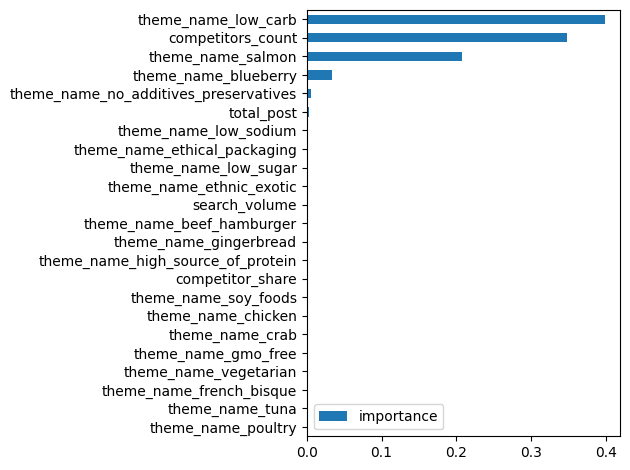

In [76]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame(
    {'importance': xgb_training_pipeline_init['XGBoost'].feature_importances_}
)

imp.index = X_train_prepared.columns

imp.sort_values('importance', inplace=True)

imp.plot(kind='barh')

##### Pipeline build based on new importance features

In [77]:
# Let's find features for some decent defaults
imp_features = [
    "theme_name_low_carb",
    "theme_name_soy_foods",
    "theme_name_salmon",
    "theme_name_no_additives_preservatives",
]

estimator = XGBRegressor()

xgb_training_pipeline2 = Pipeline([
    (
        '',
        FunctionTransformer(
            _custom_data_transform,
            kw_args={'cols_to_keep': imp_features}
        )
    ),
    ('XGBoost', XGBRegressor())
])

xgb_training_pipeline2

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f50a8ab1750>,
                                     kw_args={'cols_to_keep': ['theme_name_low_carb',
                                                               'theme_name_soy_foods',
                                                               'theme_name_salmon',
                                                               'theme_name_no_additives_preservatives']})),
                ('XGBoost',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, en...
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

##### Grid search of the estimator

In [78]:
parameters = {
   'gamma': [0.03],
   'min_child_weight': [6],
   'learning_rate': [0.1],
   'max_depth': [3],
   'n_estimators': [500], 
}
   
estimator = XGBRegressor()
xgb_grid = GridSearchCV(
   estimator,
   parameters,
   cv=2,
   n_jobs=4,
   verbose=True
)

xgb_grid.fit(X_train_prepared, y_train)

print("=========================================================")
print("The best score:", xgb_grid.best_score_)
print("=========================================================")
print("The best params", xgb_grid.best_params_)
print("=========================================================")

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/naveen/miniconda3/envs/tamle_mod5-dev/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/naveen/miniconda3/envs/tamle_mod5-dev/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/naveen/miniconda3/envs/tamle_mod5-dev/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/naveen/miniconda3/envs/tamle_mod5-dev/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarn

The best score: 0.9799968058346142
The best params {'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}


##### Pipeline build using the best estimator

In [79]:
xgb_pipeline_final = Pipeline([
    (
        '',
        FunctionTransformer(
            _custom_data_transform,
            kw_args={'cols_to_keep': imp_features}
        )
    ),
    ('XGBoost', xgb_grid.best_estimator_)
])

xgb_pipeline_final.fit(X_train_prepared, y_train)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f50a8ab1750>,
                                     kw_args={'cols_to_keep': ['theme_name_low_carb',
                                                               'theme_name_soy_foods',
                                                               'theme_name_salmon',
                                                               'theme_name_no_additives_preservatives']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_c...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [80]:
reg_tree_report = RegressionReport(
    model=xgb_pipeline_final,
    x_train=X_train_prepared,
    y_train=y_train,
    x_test= X_test_prepared,
    y_test= y_test
)

reg_tree_report.get_report(
    include_shap=False,
    file_path='regression-tree-model-report'
)

## 4. Model Comparison

Now, a comparison report of the  Linear (vs) Tree-based model  approach can be generated as follows:

**NOTE:** This code will NOT be part of the production code.

In [81]:
model_pipelines = [regression_pipeline, xgb_pipeline_final]

model_comparison_report = RegressionComparison(
    models=model_pipelines,
    x=X_train_prepared,
    y=y_train.values.ravel(),
    refit=True
)

model_comparison_report

In [82]:
metrics = model_comparison_report.get_report(file_path='regression-comparison')

SHAP values (2095, 23)
SHAP values (2095, 4)


In [83]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
", Linear Regression",6.3709,0.0864,223095.9732,4.538022e+05,0.9860
", XGBoost",417.0136,0.3004,775354.9052,1.021229e+06,0.9292


**NOTES:** The above metrics are absolute numbers and not percentages.

## <p align="center">The End</p>

---